In [1]:
import pandas as pd
import numpy as np
from my_libs import lib_tools as pt # Project Tools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import date, datetime

start_year, end_year = 2005, 2021  # période d'étude
chk = True           # display logs
sample_size = 10000  # Travail sur données samplées de df

df, dic_usagers, dic_caract, dic_lieux, dic_vehic = pt.get_work_df(start_year, end_year, sample_size, chk)


usagers :
somme des lignes 'dic': 2509620
nombre de lignes 'df' : 2509620
nombre de doublons avant traîtement : 2858
nombre de doublons après traîtement : 0

caractéristiques :
somme des lignes 'dic': 1121571
nombre de lignes 'df' : 1121571
nombre de doublons avant traîtement : 0
nombre de doublons après traîtement : 0

véhicules :
somme des lignes 'dic': 1914902
nombre de lignes 'df' : 1914902
nombre de doublons avant traîtement : 0
nombre de doublons après traîtement : 0
Véhicules en doublons vis à vis de la clé fonctionnelle avant traitement : 53
Véhicules en doublons vis à vis de la clé fonctionnelle après traitement : 0

lieux :
somme des lignes 'dic': 1121571
nombre de lignes 'df' : 1121571
nombre de doublons avant traîtement : 0
nombre de doublons après traîtement : 0


In [2]:
display_stat_data_load = chk

if display_stat_data_load:
    pt.display_stats_data_load(dic_usagers, dic_caract, dic_lieux, dic_vehic, start_year, end_year)

usagers : 

usagers 2005 : 12 colonnes x 197498 lignes
usagers 2006 : 12 colonnes x 187085 lignes
usagers 2007 : 12 colonnes x 188457 lignes
usagers 2008 : 12 colonnes x 170960 lignes
usagers 2009 : 12 colonnes x 165962 lignes
usagers 2010 : 12 colonnes x 154192 lignes
usagers 2011 : 12 colonnes x 148543 lignes
usagers 2012 : 12 colonnes x 138628 lignes
usagers 2013 : 12 colonnes x 128694 lignes
usagers 2014 : 12 colonnes x 132186 lignes
usagers 2015 : 12 colonnes x 130378 lignes
usagers 2016 : 12 colonnes x 133422 lignes
usagers 2017 : 12 colonnes x 136021 lignes
usagers 2018 : 12 colonnes x 130169 lignes
usagers 2019 : 15 colonnes x 132977 lignes
usagers 2020 : 15 colonnes x 105295 lignes
usagers 2021 : 15 colonnes x 129153 lignes

nombre de lignes min : 105295
nombre de lignes max : 197498
caract : 

caract 2005 : 16 colonnes x 87026 lignes
caract 2006 : 16 colonnes x 82993 lignes
caract 2007 : 16 colonnes x 83850 lignes
caract 2008 : 16 colonnes x 76767 lignes
caract 2009 : 16 colo

### Suppression des colonnes jugées non pertinentes

In [3]:
# relatives à une info géographique trop fine
cols_rmv = ['com', 'adr', 'lat', 'long', 'pr', 'pr1']
for col in cols_rmv:
    if col in df.columns:
        df = df.drop(columns=cols_rmv, axis=1)

# non connue en pratique avant l'accident
cols_rmv = ['obs', 'obsm', 'choc', 'manv', 'col']
for col in cols_rmv:
    if col in df.columns:
        df = df.drop(columns=cols_rmv, axis=1)

### Représentation graphique des *Null* - Suppression de variables avec plus de 8 % de Null

Colonnes supprimées : Index(['v2', 'motor', 'secu3', 'id_vehicule', 'vma', 'secu2', 'secu1', 'v1',
       'gps', 'lartpc', 'secu', 'env1', 'occutc', 'larrout', 'voie'],
      dtype='object')

             column_name  rate_missing
v2                    v2     95.249888
motor              motor     85.351741
secu3              secu3     85.349188
id_vehicule  id_vehicule     85.349188
vma                  vma     85.349188
secu2              secu2     85.349188
secu1              secu1     85.349188
v1                    v1     56.446803
gps                  gps     56.341448
lartpc            lartpc     19.694171
secu                secu     16.899849
env1                env1     15.157921
occutc            occutc     14.478519
larrout          larrout     10.182618
voie                voie      8.959407
place              place      4.896197
actp                actp      2.251869
etatp              etatp      2.250114
locp                locp      2.247840
infra              infra    

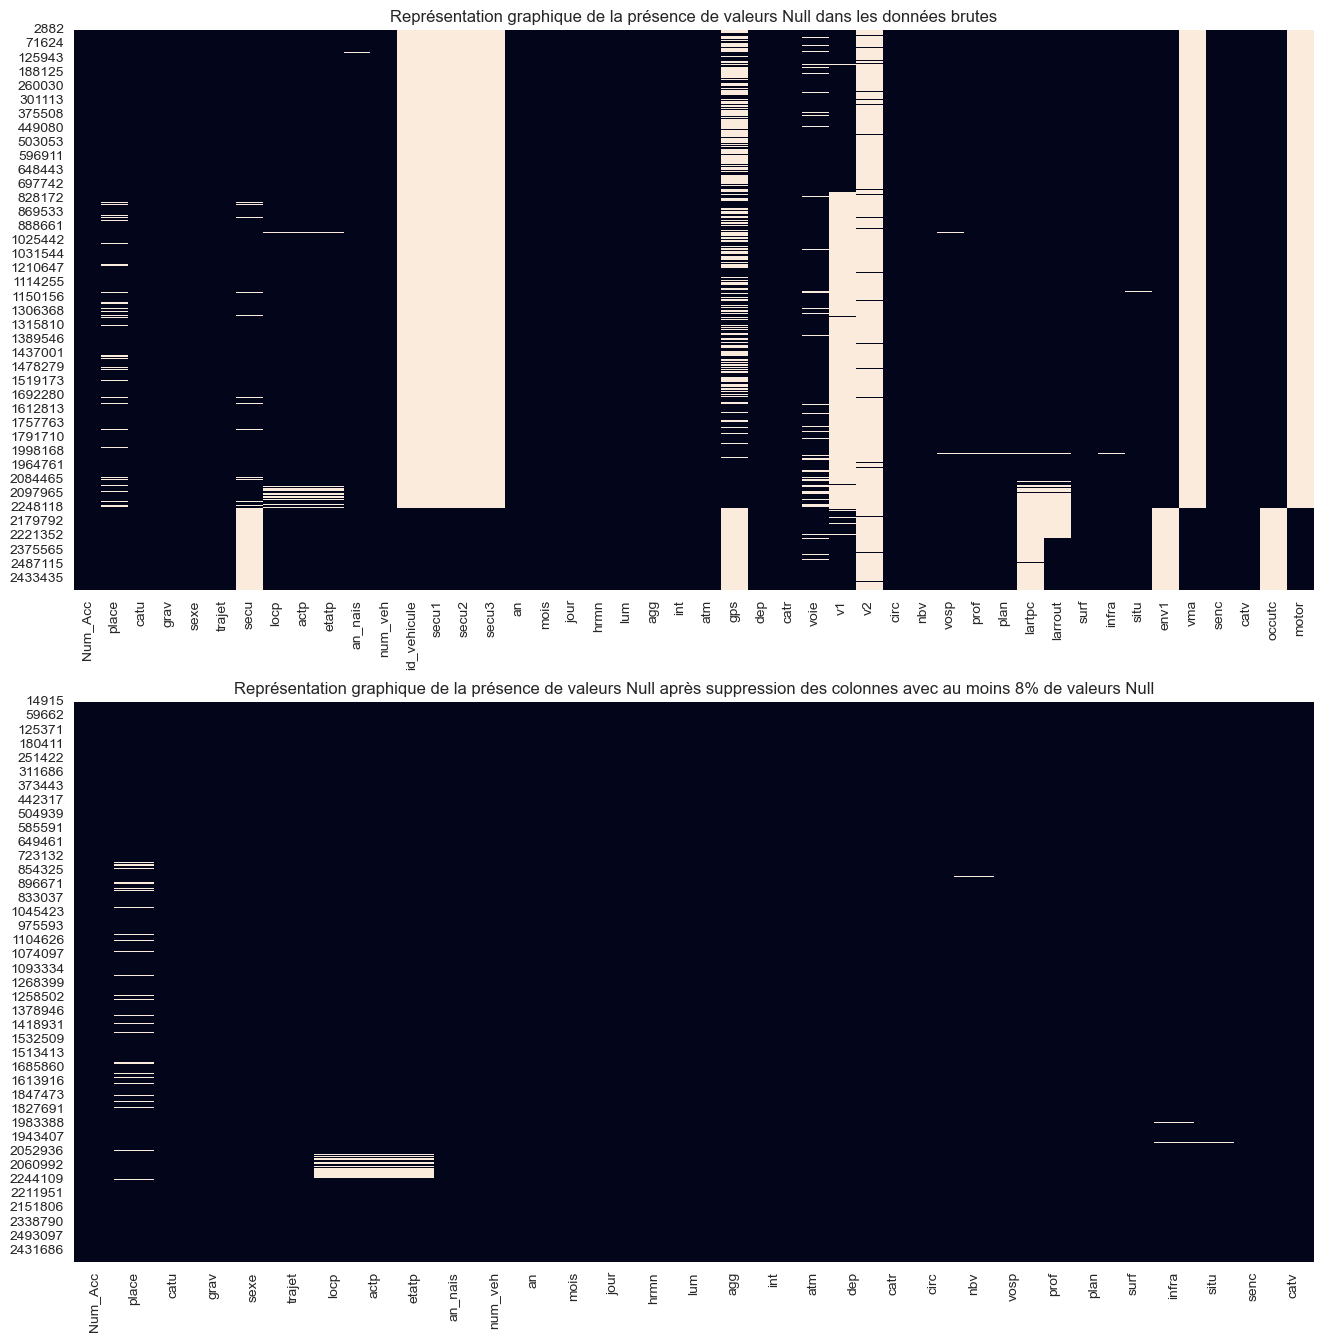

In [4]:
df_sample = df.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 16)
ax[0].set_title('Représentation graphique de la présence de valeurs Null dans les données brutes')
sns.heatmap(df_sample.isna(), cbar=False, ax=ax[0]);

df = pt.rmv_col_too_much_null(df, 0.08, chk)

df_sample = df.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

ax[1].set_title('Représentation graphique de la présence de valeurs Null après suppression des colonnes avec au moins 8% de valeurs Null')
sns.heatmap(df_sample.isna(), cbar=False, ax=ax[1]);

### Transformation des  *Null* restants en -1 (non renseigné) pour les colonnes qui l'autorisent

In [5]:
df = pt.clean_categ_not_specified(df)

### Nettoyage de l'année de naissance

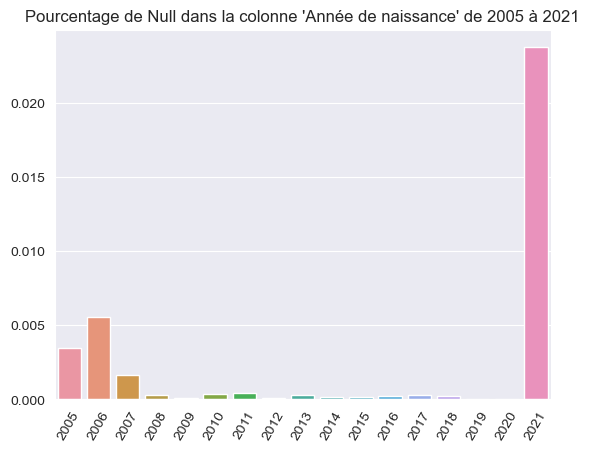

In [6]:
df[df.an_nais.isna()].shape[0]
df[df.an_nais.isna()].an.value_counts()

years = []
rate_nan = []
for year in range(start_year, end_year+1):
    years.append(year)
    rate_nan.append(df[(df.an_nais.isna()) & (df.an==year)].shape[0] / df[df.an==year].shape[0])

plt.title(f"Pourcentage de Null dans la colonne 'Année de naissance' de {start_year} à {end_year}")
ax = sns.barplot(x=years, y=rate_nan)
plt.xticks(rotation=60);

In [7]:
print("Suppression des lignes avec Null : ")
nb_bef = df.shape[0]
print(f"Nombre de lignes avant : {nb_bef}")

df = df.dropna(axis = 0, how = 'any')
nb_aft = df.shape[0]
print(f"Nombre de lignes après : {nb_aft}")
print(f"Taux de perte : {(nb_bef-nb_aft)/nb_aft*100:.2f} %")

Suppression des lignes avec Null : 
Nombre de lignes avant : 2506762
Nombre de lignes après : 2501286
Taux de perte : 0.22 %


### Création de *age* et *age_cls*

In [8]:
df = pt.create_age(df)
df = pt.create_age_cls(df)

### Encodages : *dep*,  *nbv*, *catv*, *senc*

In [9]:
from my_libs import lib_tools as pt
df = pt.clean_col_dep(df, True)
df = pt.clean_nbv(df)
df = pt.clean_catv(df)
df = pt.clean_senc(df)

Départements avant nettoyage : 
['01' '010' '02' '020' '03' '030' '04' '040' '05' '050' '06' '060' '07'
 '070' '08' '080' '09' '090' '1' '10' '100' '11' '110' '12' '120' '13'
 '130' '14' '140' '15' '150' '16' '160' '17' '170' '18' '180' '19' '190'
 '2' '20' '201' '202' '21' '210' '22' '220' '23' '230' '24' '240' '25'
 '250' '26' '260' '27' '270' '28' '280' '29' '290' '2A' '2B' '3' '30'
 '300' '31' '310' '32' '320' '33' '330' '34' '340' '35' '350' '36' '360'
 '37' '370' '38' '380' '39' '390' '4' '40' '400' '41' '410' '42' '420'
 '43' '430' '44' '440' '45' '450' '46' '460' '47' '470' '48' '480' '49'
 '490' '5' '50' '500' '51' '510' '52' '520' '53' '530' '54' '540' '55'
 '550' '56' '560' '57' '570' '58' '580' '59' '590' '6' '60' '600' '61'
 '610' '62' '620' '63' '630' '64' '640' '65' '650' '66' '660' '67' '670'
 '68' '680' '69' '690' '7' '70' '700' '71' '710' '72' '720' '73' '730'
 '74' '740' '75' '750' '76' '760' '77' '770' '78' '780' '79' '790' '8'
 '80' '800' '81' '810' '82' '820' '83'

### Affichage des modes des variables catégorielles restantes

In [10]:
# var_categ = df.select_dtypes('Int64').columns
var_categ = df.columns
col_excluded = ['Num_Acc', 'num_veh', 'age', 'hrmn', 'an', 'jour', 'an_nais', 'datetime', 'dep']

for col in var_categ:
    if not (col in col_excluded):
        modes = list(df[col].unique())
        print(f"{col}\t: {modes}")            
#         print(f"{modes}")            

place	: [1, 2, 4, 5, 3, 0, 8, 9, 7, 6, -1, 10]
catu	: [1, 2, 3, 4]
grav	: [4, 3, 1, 2]
sexe	: [1, 2, -1]
trajet	: [1, 3, 0, 5, 9, 4, 2, -1]
locp	: [0, 2, 4, 1, 5, 6, 3, 8, 7, -1, 9]
actp	: ['0', '3', '1', '5', '2', '9', '6', '4', -1, ' -1', 'B', 'A', '8', '7']
etatp	: [0, 2, 1, 3, -1]
mois	: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
lum	: [3, 1, 5, 4, 2, -1]
agg	: [2, 1]
int	: [1, 2, 9, 0, 6, 8, 3, 4, 7, 5, -1]
atm	: [1, 2, 3, 8, 9, 7, 6, 4, 5, -1]
catr	: [3, 2, 4, 6, 9, 5, 1, 7]
circ	: [2, 0, 3, 4, 1, -1]
nbv	: [2, 0, 1, 3, 4, 6, -1, 5]
vosp	: [0, 1, 3, 2, -1]
prof	: [1, 0, 2, 3, 4, -1]
plan	: [1, 3, 2, 0, 4, -1]
surf	: [1, 2, 0, 9, 7, 8, 5, 6, 3, 4, -1]
infra	: [0, 5, 4, 2, 3, 6, 1, 7, -1, 9, 8]
situ	: [1, 5, 3, 4, 0, 2, -1, 6, 8]
senc	: [-1, 1, 2]
catv	: [7, 2, -1, 1, 10, 30, 33]
age_cls	: [2, 0, 3, 1, 4]


###  Nettoyage de *hrmn* et création de *datetime* - *joursem* - *grav_lbl*

In [11]:
df = pt.clean_hrmn(df)
df = pt.create_datetime(df)
df = pt.create_joursem(df)
df = pt.create_grav_lbl(df)

### Suppression des colonnes inutiles : *an_nais*

In [12]:
df = df.drop(columns=['an_nais'], axis=1)

### Analyses croisées

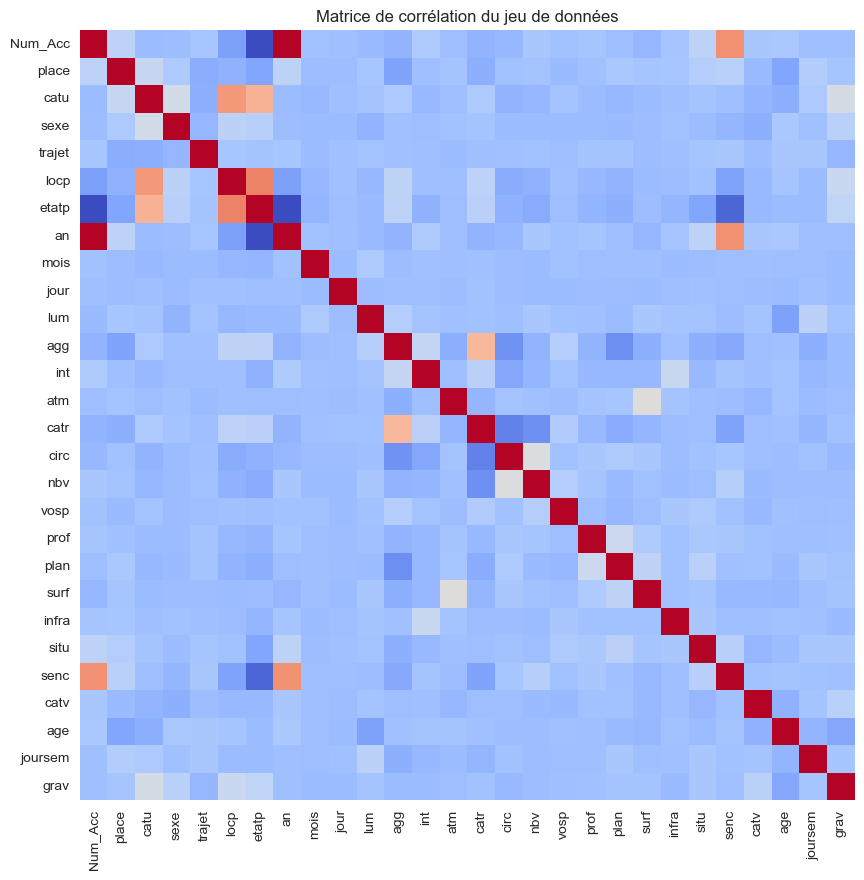

In [13]:
target = df['grav']
data = df.drop(columns=['grav'], axis=1)
# set 'grav' as last column of data
data['grav'] = target

ds = data.sample(10000)
corr = ds.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(corr, annot=False, cmap='coolwarm', cbar=False) 
ax.set_title(f"Matrice de corrélation du jeu de données");

In [14]:
# target = df['grav']
# data = df.drop(columns=['grav'], axis=1)
# # set 'grav' as last column of data
# data['grav'] = target

# ds = data.sample(10000)
# corr1 = ds[ds.grav == 1].corr()

# ds = data.sample(10000)
# corr2 = ds[ds.grav == 2].corr()

# ds = data.sample(10000)
# corr3 = ds[ds.grav == 3].corr()

# ds = data.sample(10000)
# corr4 = ds[ds.grav == 4].corr()

# fig, axs = plt.subplots(nrows=2, ncols=2)
# fig.set_size_inches(15, 15)

# axs[0,0].set_title('grav = Indemne')
# sns.heatmap(corr1, annot=False, cmap='coolwarm', ax=axs[0,0], cbar=False) 

# axs[0,1].set_title('grav = Tué')
# sns.heatmap(corr2, annot=False, cmap='coolwarm', ax=axs[0,1], cbar=False) 

# axs[1,0].set_title('grav = Blessé hospitalisé')
# sns.heatmap(corr3, annot=False, cmap='coolwarm', ax=axs[1,0], cbar=False) 

# axs[1,1].set_title('grav = Blessé léger')
# sns.heatmap(corr4, annot=False, cmap='coolwarm', ax=axs[1,1], cbar=False);

grav_lbl  Blessé hospitalisé  Blessé léger   Indemne       Tué
joursem                                                       
dimanche            0.241651      0.353974  0.368143  0.036232
jeudi               0.188608      0.366887  0.420382  0.024122
lundi               0.188687      0.371921  0.414786  0.024606
mardi               0.185075      0.371464  0.420565  0.022897
mercredi            0.186120      0.369508  0.421018  0.023354
samedi              0.221567      0.352225  0.394572  0.031637
vendredi            0.194413      0.361406  0.418343  0.025838


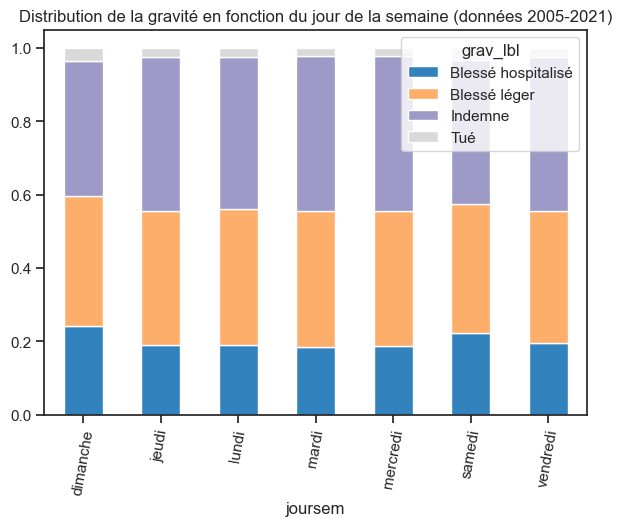

In [15]:
colormap = 'tab20c'
df_tmp = df['joursem'].replace(to_replace=[0,1,2,3,4,5,6], value=['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche'])
df_cross = pd.crosstab(df_tmp, df['grav_lbl'], normalize='index')
print(df_cross)

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax,
                      title=f"Distribution de la gravité en fonction du jour de la semaine (données {start_year}-{end_year})",
                      colormap=colormap)
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_16712\1446065007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['sexe'] = df_tmp['sexe'].astype('str').replace(['1','2'], ['masculin', 'féminin'])


grav_lbl  Blessé hospitalisé  Blessé léger   Indemne       Tué
sexe                                                          
-1                  0.000000      0.000000  1.000000  0.000000
féminin             0.192911      0.433952  0.353883  0.019254
masculin            0.203465      0.330056  0.436076  0.030402
sexe                      -1   féminin  masculin
grav_lbl                                        
Blessé hospitalisé  0.000000  0.314664  0.685336
Blessé léger        0.000000  0.389011  0.610989
Indemne             0.000002  0.282115  0.717883
Tué                 0.000000  0.234708  0.765292


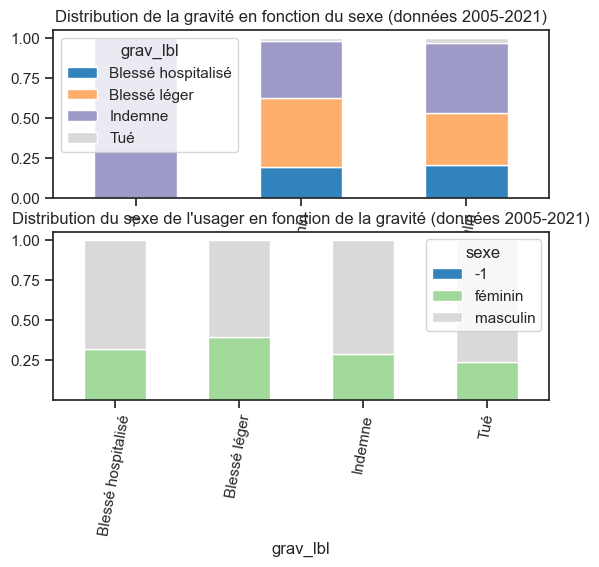

In [16]:
colormap = 'tab20c'

df_tmp = df[['sexe', 'grav_lbl']]
df_tmp['sexe'] = df_tmp['sexe'].astype('str').replace(['1','2'], ['masculin', 'féminin'])
df_cross_1 = pd.crosstab(df_tmp['sexe'], df_tmp['grav_lbl'], normalize='index')
df_cross_2 = pd.crosstab(df_tmp['grav_lbl'], df_tmp['sexe'], normalize='index')

print(df_cross_1)
print(df_cross_2)

sns.set_theme(style="ticks")

fig, axs = plt.subplots(2,1)
chart = df_cross_1.plot(kind="bar", stacked=True, rot=0, ax=axs[0], 
                      title=f"Distribution de la gravité en fonction du sexe (données {start_year}-{end_year})", 
                      colormap=colormap)
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")

chart = df_cross_2.plot(kind="bar", stacked=True, rot=0, ax=axs[1], 
                      title=f"Distribution du sexe de l'usager en fonction de la gravité (données {start_year}-{end_year})", 
                      colormap=colormap)
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")


### Evolution de gravité *Blessé hospitalisé* en 2019?

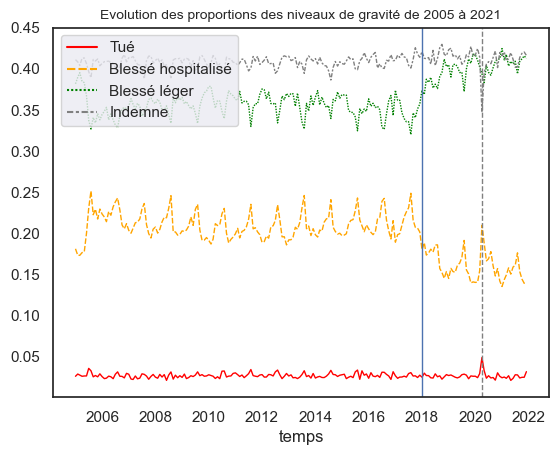

In [17]:
tue     = []
bless_l = []
bless_h = []
indemne = []
y_m     = []
years   = range(start_year, end_year+1)
months  = range(1, 13)

import datetime

df_tmp = df

for year in years:
    for month in months:
#         df_tmp = df[(df.datetime.dt.year == year) & (df.datetime.dt.month == month)]
        df_tmp = df[(df.an==year) & (df.mois==month)]
        if 2 in df_tmp.grav.value_counts(normalize=True).index: 
            tue.append(df_tmp.grav.value_counts(normalize=True)[2]) 
        else :
            tue.append(tue[-1])
        if 3 in df_tmp.grav.value_counts(normalize=True).index: 
            bless_h.append(df_tmp.grav.value_counts(normalize=True)[3])
        else:
            bless_h.append(bless_h[-1])
        if 4 in df_tmp.grav.value_counts(normalize=True).index: 
            bless_l.append(df_tmp.grav.value_counts(normalize=True)[4])
        else:
            bless_l.append(bless_l[-1])
        if 1 in df_tmp.grav.value_counts(normalize=True).index: 
            indemne.append(df_tmp.grav.value_counts(normalize=True)[1])
        else:
            indemne.append(indemne[-1])
        y_m.append(datetime.datetime(year, month, 1))

  
data = pd.DataFrame({'Tué':tue, 'Blessé hospitalisé':bless_h, 'Blessé léger':bless_l, 'Indemne':indemne, 'temps':y_m})
data = data.set_index('temps')

sns.set_theme(style="white", palette=None)
ax = sns.lineplot(data=data, palette=['red','orange','green','gray'], linewidth=1) #.set_title("Evolution des proportions des niveaux de gravité en fonction du temps")
ax.axes.set_title(f"Evolution des proportions des niveaux de gravité de {start_year} à {end_year}",fontsize=10)
sns.set(rc={'figure.figsize':(15,6)})
plt.axvline(datetime.datetime(2018, 1, 1), linewidth=1)
plt.axvline(datetime.datetime(2020, 4, 1), linestyle='--', color='gray', linewidth=1)
plt.legend(loc='upper left');

In [18]:
# colormap = 'tab20c'
# col = 'place'

# col_excluded = ['Num_Acc', 'num_veh', 'age', 'hrmn', 'dep', 'an', 'jour', 'an_nais']

# sns.set_theme(style="ticks")
# fig, axs = plt.subplots(7,4)
# fig.set_size_inches(20, 15)
# axs = np.reshape(axs, -1)
# plt.show()

# k = 0
# for col in df.columns:
#     if not (col in col_excluded) and (k <= 1):    
# #         if (k%5 == 0) : 
#         print(k)
#         df_cross = pd.crosstab(df[col], df.grav_lbl, normalize='index')
#         chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=axs[k], title=f"{col}", colormap=colormap)
# #         axs[k].yaxis.set_visible(False)
# #         chart.set_xticklabels(chart.get_xticklabels(), rotation=80)        
#         k += 1

In [19]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2501286 entries, 0 to 2506761
Data columns (total 35 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Num_Acc   2501286 non-null  int64         
 1   place     2501286 non-null  Int64         
 2   catu      2501286 non-null  Int64         
 3   grav      2501286 non-null  Int64         
 4   sexe      2501286 non-null  Int64         
 5   trajet    2501286 non-null  Int64         
 6   locp      2501286 non-null  Int64         
 7   actp      2501286 non-null  object        
 8   etatp     2501286 non-null  Int64         
 9   num_veh   2501286 non-null  object        
 10  an        2501286 non-null  Int64         
 11  mois      2501286 non-null  Int64         
 12  jour      2501286 non-null  Int64         
 13  hrmn      2501286 non-null  object        
 14  lum       2501286 non-null  Int64         
 15  agg       2501286 non-null  Int64         
 16  int       2501286 

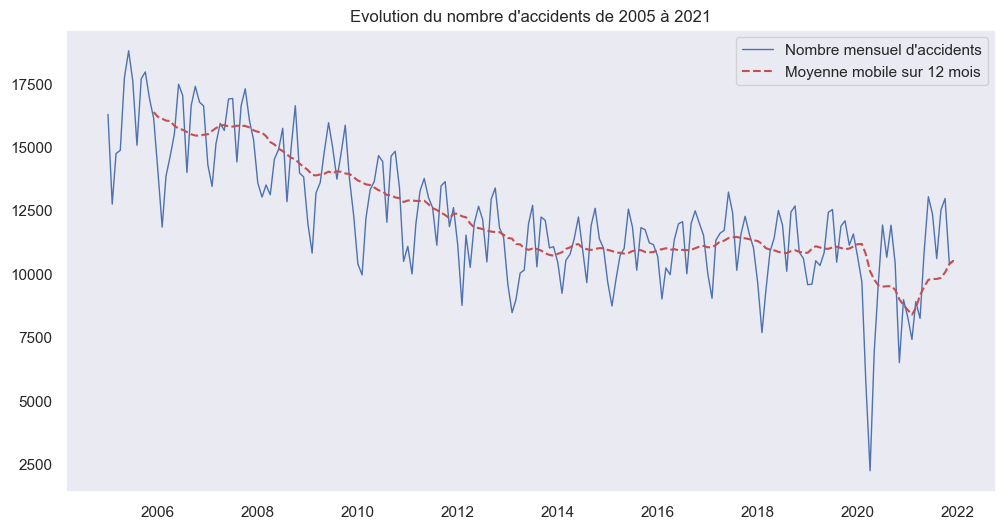

In [20]:
acc    = []
y_m    = []
years  = range(start_year, end_year+1)
months = range(1, 13)

import datetime

df_tmp = df

for year in years:
    for month in months:
        df_tmp = df[(df.an==year) & (df.mois==month)]
        acc.append(df_tmp.shape[0])
        y_m.append(datetime.datetime(year, month, 1))
  
df_acc = pd.DataFrame({'Accidents':acc, 'temps':y_m})
df_acc = df_acc.set_index('temps')

acc_ma = df_acc.Accidents.rolling(12).mean()
df_acc_ma = pd.DataFrame({'Moy mobile':acc_ma, 'temps':y_m})
df_acc_ma = df_acc_ma.set_index('temps')

plt.figure(figsize=(12,6))
plt.plot(df_acc, 'b', linewidth=1, label=f"Nombre mensuel d'accidents")
plt.plot(df_acc_ma, 'r', linestyle='dashed', label=f"Moyenne mobile sur 12 mois")
plt.title(f"Evolution du nombre d'accidents de {start_year} à {end_year}")
plt.grid()
plt.legend();

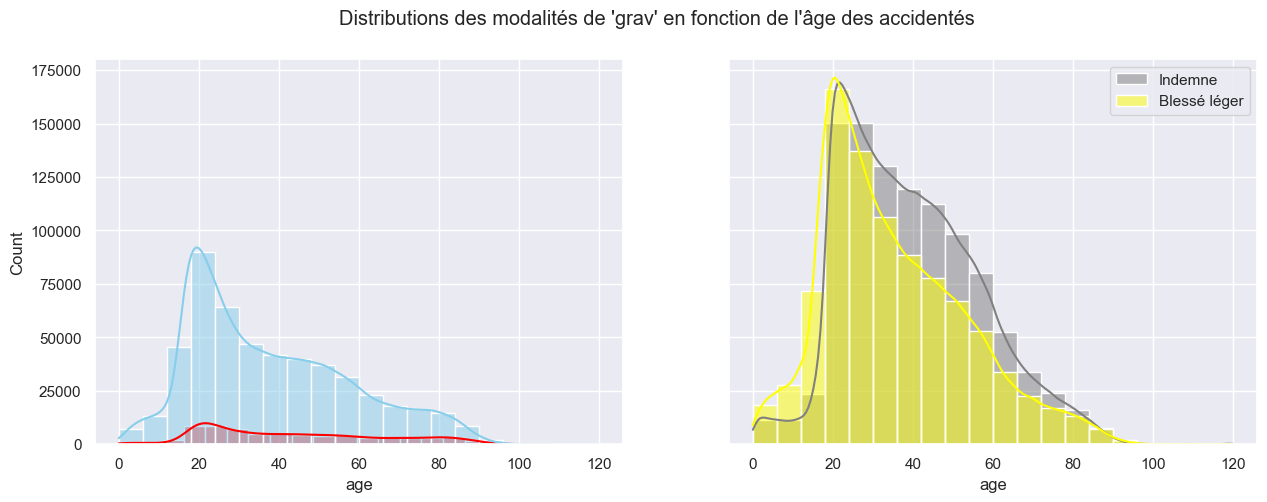

In [21]:
# sns.histplot(data=df[df.grav==2], x='age', bins=30)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle(f"Distributions des modalités de 'grav' en fonction de l'âge des accidentés")
sns.histplot(data=df[df.grav==2], x="age", color="red", label="Tué", kde=True, bins=20, ax=axs[0])
sns.histplot(data=df[df.grav==3], x="age", color="skyblue", label="Blessé hospitalisé", kde=True, bins=20, ax=axs[0])
sns.histplot(data=df[df.grav==1], x="age", color="gray", label="Indemne", kde=True, bins=20, ax=axs[1])
sns.histplot(data=df[df.grav==4], x="age", color="yellow", label="Blessé léger", kde=True, bins=20, ax=axs[1])

plt.legend();

In [22]:
print(f"Proportion de tués : {df[df.grav==2].shape[0]/df.shape[0]}")
print(f"Proportion de blessés hospitalisés : {df[df.grav==3].shape[0]/df.shape[0]}")
print(f"Proportion de blessés légers : {df[df.grav==4].shape[0]/df.shape[0]}")
print(f"Proportion de personnes indemnes : {df[df.grav==1].shape[0]/df.shape[0]}")

Proportion de tués : 0.026765032067504475
Proportion de blessés hospitalisés : 0.20002150893580342
Proportion de blessés légers : 0.3639531824829308
Proportion de personnes indemnes : 0.40926027651376135


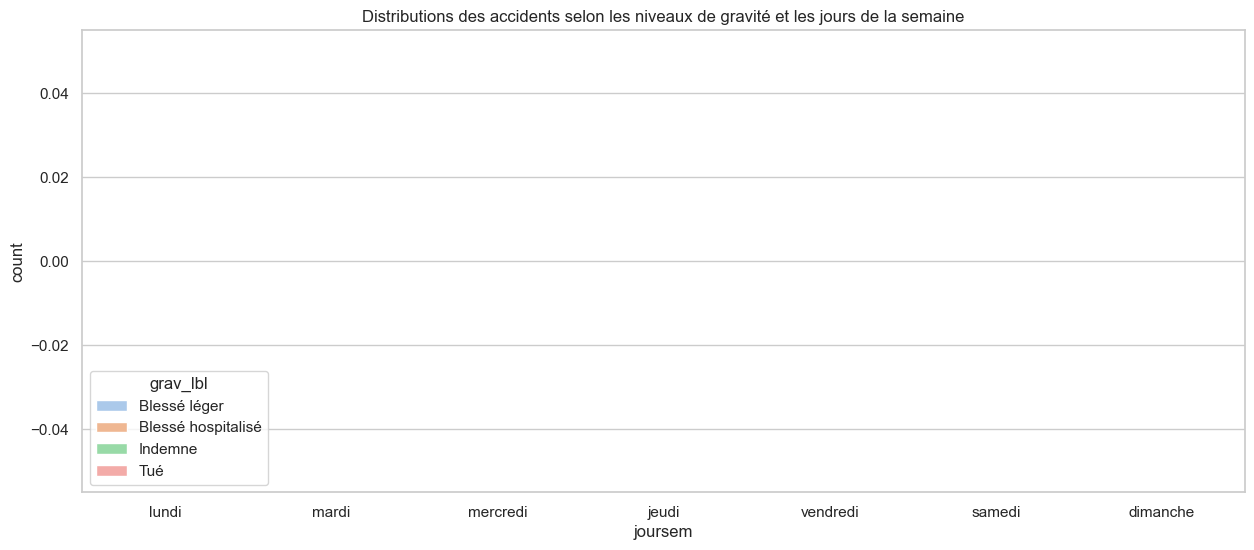

In [23]:
sns.set_theme(style="whitegrid", palette="pastel")
df_tmp = df[['grav_lbl', 'joursem']]
plt.title(f"Distributions des accidents selon les niveaux de gravité et les jours de la semaine")
ax = sns.countplot(data=df_tmp, x="joursem", hue="grav_lbl", 
                   order=['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']);

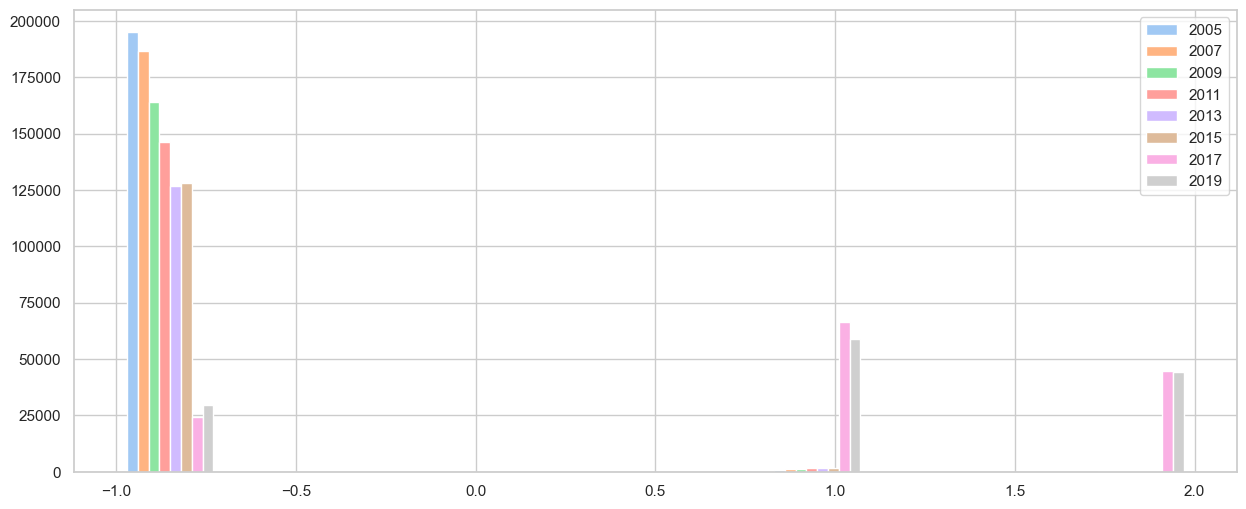

In [24]:
df.senc.unique()
df_lst = []
for year in np.arange(start_year, end_year, 2):
    df_lst.append(df[df.an==year].senc)

plt.hist(df_lst, label=np.arange(start_year, end_year, 2));
plt.legend()